In [1]:
import geopandas as gpd
import time
from matplotlib import pyplot as plt
from geopandas.tools import sjoin

In [2]:
eco_fi = r"D:/projects/RD/night_fire/ecoregions_L1_CONUS.shp"
shp_fi = r"D:\projects\RD\night_fire\modis_fire_points\DL_FIRE_M6_50643\fire_archive_M6_50643.shp"

In [3]:
t0 = time.time()
df = gpd.read_file(shp_fi)
t1 = time.time()
print('geopandas: {} seconds'.format(t1-t0))

geopandas: 182.72180223464966 seconds


In [5]:
df.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,-28.7608,20.6512,332.9,1.3,1.1,2004-01-01,0006,Aqua,MODIS,100,6.2,292.8,49.2,N,0,POINT (20.6512 -28.7608)
1,-28.7593,20.6378,303.6,1.3,1.1,2004-01-01,0006,Aqua,MODIS,56,6.2,291.0,8.8,N,0,POINT (20.6378 -28.7593)
2,-34.0107,18.6602,307.7,1.2,1.1,2004-01-01,0007,Aqua,MODIS,72,6.2,287.6,12.4,N,0,POINT (18.6602 -34.0107)
3,35.9348,140.6742,301.6,1.9,1.4,2004-01-01,0103,Terra,MODIS,0,6.2,286.7,15.2,D,2,POINT (140.6742 35.9348)
4,-19.5890,144.4041,317.4,3.6,1.8,2004-01-01,0118,Terra,MODIS,54,6.2,300.4,34.1,D,0,POINT (144.4041 -19.589)


In [6]:
eco_df = gpd.read_filele(eco_fi)
eco_df.head()

,index,NA_L1CODE,NA_L1NAME,NA_L1KEY,Shape_Leng,Shape_Area,geometry
0,2002,8,EASTERN TEMPERATE FORESTS,8 EASTERN TEMPERATE FORESTS,2293.192372,3.374335e+05,POLYGON ((-7818493.630414151 5417164.019218392...
1,2014,8,EASTERN TEMPERATE FORESTS,8 EASTERN TEMPERATE FORESTS,33292.842298,7.308003e+06,POLYGON ((-7786599.018038419 5432578.144002809...
2,2015,8,EASTERN TEMPERATE FORESTS,8 EASTERN TEMPERATE FORESTS,6874.214627,7.997862e+05,(POLYGON ((-7783035.451414463 5432482.60428471...
3,2019,8,EASTERN TEMPERATE FORESTS,8 EASTERN TEMPERATE FORESTS,101816.915189,2.537028e+07,(POLYGON ((-7780295.298771944 5443353.24114592...
4,2028,8,EASTERN TEMPERATE FORESTS,8 EASTERN TEMPERATE FORESTS,15708.177112,2.841671e+06,"POLYGON ((-7742068.185564543 5444572.93132353,..."


In [7]:
eco_df.crs, df.crs

({'init': 'epsg:3857'}, {'init': 'epsg:4326'})

In [8]:
eco_df_temp = eco_df.to_crs(epsg=4326)

In [7]:
df_sub = df.query('CONFIDENCE > 50')
daynight = list(df_sub.groupby('DAYNIGHT'))
df_day = daynight[0][1]
df_night = daynight[1][1]

In [65]:
pointInPolys_night = sjoin(df_night, eco_df_temp, how='left')
pointByPoly_night_count = pointInPolys.groupby('NA_L1NAME').agg(['count'])
pointsByPoly_night_mean = pointInPolys.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['mean'])
pointsByPoly_night_std = pointInPolys.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['std'])

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [66]:
pointInPolys_night.shape

(478857, 23)

In [67]:
valid_names = list(pointsByPoly_night_mean.index)
temp = eco_df_temp[eco_df_temp['NA_L1NAME'].isin(valid_names)].dissolve(by='NA_L1NAME')
pointsByPoly_night_mean['geometry'] = temp['geometry']

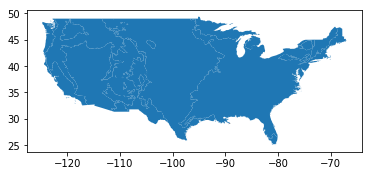

In [86]:
pointsByPoly_night_mean['geometry'] = temp['geometry']
pointsByPoly_night_mean_gdf = gpd.GeoDataFrame(pointsByPoly_night_mean) # need to set CRS after this step
pointsByPoly_night_mean_gdf.plot()

In [88]:
pointsByPoly_night_mean_gdf.index, pointsByPoly_night_mean_gdf.columns

(Index(['EASTERN TEMPERATE FORESTS', 'GREAT PLAINS', 'MARINE WEST COAST FOREST',
        'MEDITERRANEAN CALIFORNIA', 'NORTH AMERICAN DESERTS',
        'NORTHERN FORESTS', 'NORTHWESTERN FORESTED MOUNTAINS',
        'SOUTHERN SEMIARID HIGHLANDS', 'TEMPERATE SIERRAS',
        'TROPICAL WET FORESTS', 'WATER'],
       dtype='object', name='NA_L1NAME'),
 MultiIndex(levels=[['CONFIDENCE', 'BRIGHTNESS', 'FRP', 'geometry'], ['mean', '']],
            codes=[[0, 1, 2, 3], [0, 0, 0, 1]]))

In [97]:
pointsByPoly_night_mean_gdf.columns = pointsByPoly_night_mean_gdf.columns.droplevel(level=1)
pointsByPoly_night_mean_gdf.head()

,CONFIDENCE,BRIGHTNESS,FRP,geometry
NA_L1NAME,,,,
EASTERN TEMPERATE FORESTS,62.658697,317.392281,28.651420,(POLYGON ((-76.50260500400384 36.9151422099771...
GREAT PLAINS,65.552052,319.660586,32.922561,(POLYGON ((-94.78492038041986 29.5393948936631...
MARINE WEST COAST FOREST,64.904730,318.218986,47.464324,(POLYGON ((-122.4951834935165 37.6264126249729...
MEDITERRANEAN CALIFORNIA,69.443460,327.629612,74.752899,(POLYGON ((-120.8582088943627 35.3388537584825...
NORTH AMERICAN DESERTS,72.538562,330.119477,85.634662,(POLYGON ((-116.3880525722735 44.7207449370151...


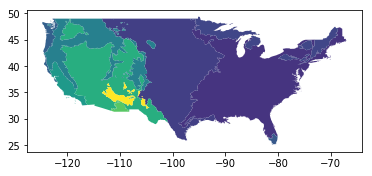

In [98]:
pointsByPoly_night_mean_gdf.plot(column='FRP')

In [99]:
pointsByPoly_night_mean_gdf.crs

## Workflow that can be wrapped into a function

### aggregation

In [ ]:
# subset the query by any number of things... CONFIDENCE, month, etc
df_sub = df.query('CONFIDENCE > 50')

# more queries...

# separate into daynight classes
daynight = list(df_sub.groupby('DAYNIGHT'))
df_day = daynight[0][1]
df_night = daynight[1][1]

# perform aggregations. eco_df_temp is a polygon feature class to do summaries. replace with grid shapefile
## for night
pointInPolys_night = sjoin(df_night, eco_df_temp, how='left')
pointByPoly_night_count = pointInPolys_night.groupby('NA_L1NAME').agg(['count'])
pointsByPoly_night_mean = pointInPolys_night.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['mean'])
pointsByPoly_night_std = pointInPolys_night.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['std'])

## for day
pointInPolys_day = sjoin(df_night, eco_df_temp, how='left')
pointByPoly_day_count = pointInPolys_day.groupby('NA_L1NAME').agg(['count'])
pointsByPoly_day_mean = pointInPolys_day.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['mean'])
pointsByPoly_day_std = pointInPolys_day.groupby('NA_L1NAME')['CONFIDENCE', 'BRIGHTNESS', 'FRP'].agg(['std'])

## assign geometries
valid_names = list(pointsByPoly_night_mean.index)
temp = eco_df_temp[eco_df_temp['NA_L1NAME'].isin(valid_names)].dissolve(by='NA_L1NAME')
pointsByPoly_night_mean['geometry'] = temp['geometry']
pointsByPoly_night_mean_gdf = gpd.GeoDataFrame(pointsByPoly_night_mean) # need to set CRS after this step

# drop the agg index from the columns
pointsByPoly_night_mean_gdf.columns = pointsByPoly_night_mean_gdf.columns.droplevel(level=1)

### affine matrix to grid

In [117]:
import rasterio as rio
import numpy as np

with rio.open(r"D:\projects\RD\south_africa\landsat\LE071680772007051501T1-SC20180911041415\LE07_L1TP_168077_20070515_20170103_01_T1_b1.tif") as src:
              prof = src.profile

In [118]:
prof

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 8001, 'height': 6951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32636'), 'transform': Affine(30.0, 0.0, 270585.0,
       0.0, -30.0, -2610885.0), 'tiled': False, 'interleave': 'band'}

In [119]:
prof['crs'], prof['transform']

(CRS.from_dict(init='epsg:32636'), Affine(30.0, 0.0, 270585.0,
        0.0, -30.0, -2610885.0))

In [120]:
tf = prof['transform']
pix_x_size = tf.a
pix_y_size = tf.e
ul_x = tf.c
ul_y = tf.f
num_x = int(prof['width'])
num_y = int(prof['height'])

pix_x_size, pix_y_size, ul_x, ul_y

(30.0, -30.0, 270585.0, -2610885.0)

In [121]:
left_x_end = ul_x + pix_x_size*num_x
top_y_end = ul_y + pix_y_size*num_y

left_x_all = np.arange(ul_x, left_x_end, pix_x_size)
right_x_all = left_x_all + pix_x_size
top_y_all = np.arange(ul_y, top_y_end, pix_y_size)
bot_y_all = top_y_all + pix_y_size

In [125]:
from shapely.geometry import box

polys = [box(left_x_all[i], bot_y_all[j], right_x_all[i], top_y_all[j]) for i in range(int(num_x/8)) for j in range(int(num_y/8))]

In [130]:
test_map = gpd.GeoDataFrame({'geometry':polys})

from fiona.crs import from_epsg

test_map.crs = from_epsg(32636)

In [131]:
test_map.to_file(r'D:\projects\RD\misc\test_tile\landsat_tile.shp')

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [132]:
del polys
del test_map

### try rounding and binning approach


In [137]:
# make rounding function:
def round_to_val(a, round_val):
    return np.round( np.array(a, dtype=float) / round_val) * round_val


# df_day
df_day['lat_round'] = round_to_val(df_day['LATITUDE'].values, 0.5)
df_day['lon_round'] = round_to_val(df_day['LONGITUDE'].values, 0.5)

# making dataframes and grouping stuff
group_xy = df_day.groupby(['lon_round', 'lat_round'])

# calculating the mean, write to csv, which saves the file with:
# [x_round, y_round, z_mean] columns.  You can exit Python and then start up 
# later to clear memory if that's an issue.
group_mean = group_xy.mean()
group_count = group_xy.count()

In [136]:
group_mean.head()

,,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,CONFIDENCE,BRIGHT_T31,FRP,TYPE
lon_round,lat_round,,,,,,,,,
-179.0,67.0,67.041650,-178.913750,305.100000,1.600000,1.250000,57.000000,289.90,11.550000,0.0
-177.5,28.0,28.199800,-177.381400,312.100000,1.000000,1.000000,53.000000,299.80,6.700000,3.0
-176.5,0.0,0.193817,-176.479083,315.666667,1.116667,1.050000,64.000000,303.15,10.916667,3.0
-175.5,-15.5,-15.634267,-175.647900,318.933333,1.133333,1.066667,64.333333,304.80,14.666667,3.0
-172.5,-13.5,-13.523880,-172.584260,317.860000,1.540000,1.180000,62.200000,301.56,16.320000,0.0


In [138]:
group_count.head()

,,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
lon_round,lat_round,,,,,,,,,,,,,,,,
-179.0,67.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
-177.5,28.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
-176.5,0.0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
-175.5,-15.5,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
-172.5,-13.5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [141]:
group_count.shape, group_mean.shape, df_day.shape, group_count.columns, group_mean.columns

((31308, 16),
 (31308, 9),
 (3621212, 18),
 Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
        'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
        'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry'],
       dtype='object'),
 Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'CONFIDENCE',
        'BRIGHT_T31', 'FRP', 'TYPE'],
       dtype='object'))

In [144]:
from shapely.geometry import Point

In [151]:
group_count['geometry'] = list(map(Point, list(group_count.index)))

In [153]:
group_count_gdf = gpd.GeoDataFrame(group_count)
group_count_gdf.crs = from_epsg(4326)

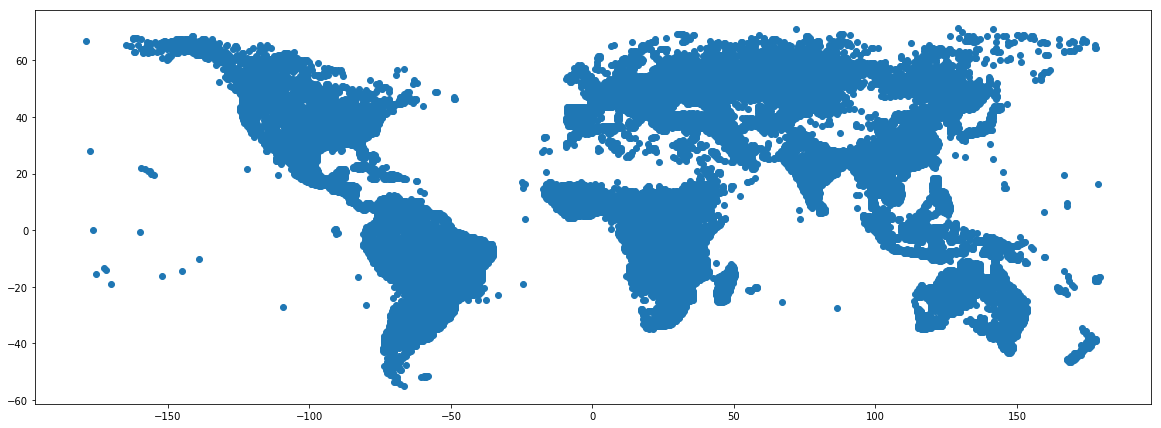

In [155]:
group_count_gdf.plot(figsize=(20,10))

In [163]:
group_count_gdf['count_perc'] = group_count_gdf['FRP'] / df_sub.shape[0]
group_count_gdf.to_file(r'D:\projects\RD\misc\test_tile\day_counts_agg_perc.shp')

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [168]:
int(group_count_gdf.crs['init'].split(':')[1])

4326

## try to import the function and use it!

In [8]:
from helpers import spatial_agg_point_df

In [9]:
import numpy as np
from shapely.geometry import Point
from fiona.crs import from_epsg

def spatial_agg_point_df(gdf, agg_val=0.5, calc='mean', epsg=4326):
    ''' takes a geodata frame and aggregates to agg_val by calculation specified in calc'''
    
    # Make rounding function:
    def round_to_val(a, round_val):
        return np.round( np.array(a, dtype=float) / round_val) * round_val
    
    
    # Record the CRS epsg code of the incoming gdf
    if epsg is None:
        epsg_code = int(gdf.crs['init'].split(':')[1])
    else:
        epsg_code=epsg
    
    # Create the rounded coordinates
    gdf['lat_round'] = round_to_val(gdf['LATITUDE'].values, agg_val)
    gdf['lon_round'] = round_to_val(gdf['LONGITUDE'].values, agg_val)

    # Making dataframes and grouping stuff
    group_xy = gdf.groupby(['lon_round', 'lat_round'])

    # Calculating the value specified by calc
    if calc == 'mean':
        group_calc = group_xy.mean()
    elif calc == 'count':
        group_calc = group_xy.count()
    elif calc == 'std':
        group_calc = group_xy.std()
    elif calc == 'sum':
        group_calc = group_xy.sum()
    else:
        raise ValueError('calc {} is not supported. Please use one of [mean, count, std, sum]'.format(calc))
        
    # Introduce the geometry from the rounding
    group_calc['geometry'] = list(map(Point, list(group_calc.index)))
    
    # convert to geodataframe and assign crs
    group_calc = gpd.GeoDataFrame(group_calc)
    group_calc.crs = from_epsg(epsg_code)
    
    return group_calc
    

In [10]:
# Use the spatial_agg_point_df function to aggregate the night dataframe by mean across 0.5 degree resolution via rounding
df_night_agg = spatial_agg_point_df(df_night, agg_val=0.5, calc='mean', epsg=4326)

In [11]:
df_night_agg.head()

,,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,CONFIDENCE,BRIGHT_T31,FRP,TYPE,geometry
lon_round,lat_round,,,,,,,,,,
-175.0,-19.5,-19.730133,-175.069767,309.600,1.033333,1.00,65.666667,292.333333,9.200,0.0,POINT (-175 -19.5)
-163.5,65.0,65.120500,-163.262100,306.400,1.000000,1.00,68.000000,281.600000,10.000,0.0,POINT (-163.5 65)
-163.0,65.0,64.960320,-163.087740,311.120,1.100000,1.04,79.600000,284.660000,14.720,0.0,POINT (-163 65)
-160.5,65.5,65.279025,-160.551275,309.525,2.450000,1.50,71.250000,276.050000,51.325,0.0,POINT (-160.5 65.5)
-159.5,22.0,21.943400,-159.637300,367.000,1.000000,1.00,100.000000,294.400000,108.500,0.0,POINT (-159.5 22)


In [12]:
df_night_agg_std = spatial_agg_point_df(df_night, agg_val=0.5, calc='std', epsg=4326)

In [13]:
df_night_agg_std.head()

,,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,CONFIDENCE,BRIGHT_T31,FRP,TYPE,geometry
lon_round,lat_round,,,,,,,,,,
-175.0,-19.5,0.001626,0.002987,2.553429,0.057735,0.000000,12.583057,1.101514,2.551470,0.0,POINT (-175 -19.5)
-163.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-163.5 65)
-163.0,65.0,0.091691,0.091321,5.494725,0.100000,0.054772,14.501724,1.558204,3.164964,0.0,POINT (-163 65)
-160.5,65.5,0.010683,0.028260,4.910109,0.700000,0.200000,13.073510,4.973597,26.562050,0.0,POINT (-160.5 65.5)
-159.5,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-159.5 22)


In [14]:
df_night_agg_count = spatial_agg_point_df(df_night, agg_val=0.5, calc='count', epsg=4326)
df_day_agg_count = spatial_agg_point_df(df_day, agg_val=0.5, calc='count', epsg=4326)

In [15]:
df_night_agg_count['night_perc'] = df_night_agg_count['FRP'] / (df_night_agg_count['FRP'] + df_day_agg_count['FRP'])
df_night_agg_count['night_perc'] *= 100

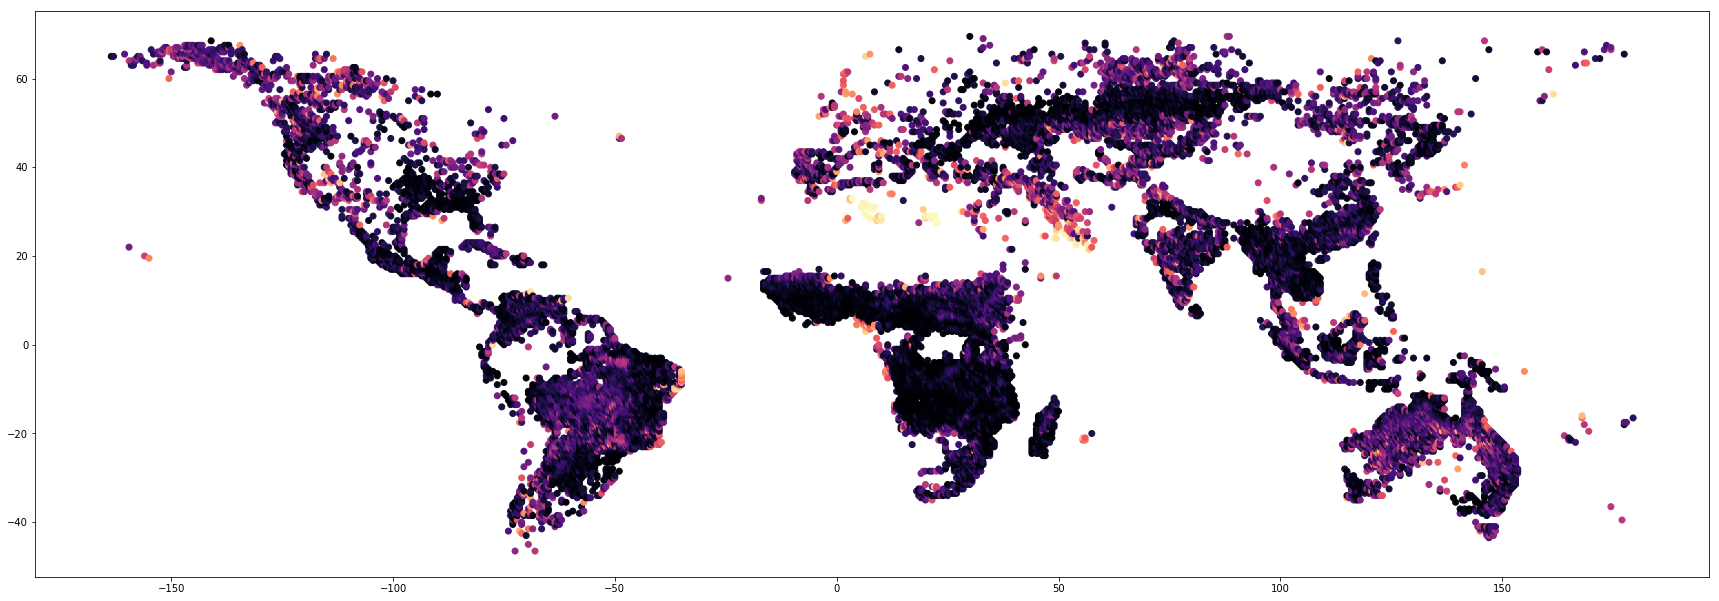

In [16]:
df_night_agg_count.dropna().plot(column='night_perc', cmap='magma', figsize=(30,20))

In [17]:
df_night_agg_count.head()

,,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry,night_perc
lon_round,lat_round,,,,,,,,,,,,,,,,,
-175.0,-19.5,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,POINT (-175 -19.5),NaN
-163.5,65.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,POINT (-163.5 65),3.571429
-163.0,65.0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,POINT (-163 65),12.820513
-160.5,65.5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,POINT (-160.5 65.5),26.666667
-159.5,22.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,POINT (-159.5 22),33.333333


## use a template raster for gridding

In [18]:
import rasterio as rio
from rasterio import features

s3_ras = 's3://mf-nwp-models/arpege-world/v2/2019-05-09/00/WIND/agl/9h.grib2'
with rio.open(s3_ras) as src:
    prof = src.profile
    meta = src.meta
    out_arr = src.read(1)*0
    out_arr = out_arr.astype('float32')

meta.update(count=1)
meta.update(dtype='float32')
out_fn = r'D:\projects\RD\misc\test_tile\day_counts_agg_perc.tif'
df_2_write = df_night_agg_count.dropna()
with rio.open(out_fn, 'w', **meta) as out:

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df_2_write.geometry, df_2_write.night_perc))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

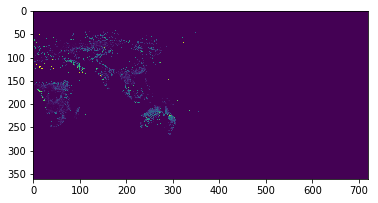

In [19]:
with rio.open(out_fn) as src:
    arr = src.read(1)
    
plt.imshow(arr)

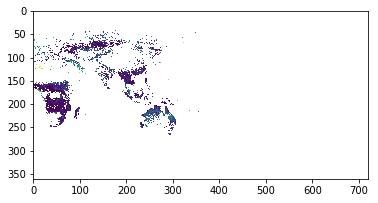

In [20]:
plt.imshow(np.ma.masked_equal(arr,0))

In [21]:
prof, meta

({'driver': 'GRIB', 'dtype': 'float64', 'nodata': None, 'width': 720, 'height': 361, 'count': 24, 'crs': CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]'), 'transform': Affine(0.5, 0.0, -0.25,
        0.0, -0.5, 90.25), 'tiled': False},
 {'driver': 'GRIB',
  'dtype': 'float32',
  'nodata': None,
  'width': 720,
  'height': 361,
  'count': 1,
  'crs': CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]'),
  'transform': Affine(0.5, 0.0, -0.25,
         0.0, -0.5, 90.25)})

In [23]:
meta['transform']

Affine(0.5, 0.0, -0.25,
       0.0, -0.5, 90.25)

In [26]:
# upper left lon, lat
help(rio.Affine)

Help on class Affine in module affine:

class Affine(Affine)
 |  Two dimensional affine transform for 2D linear mapping.
 |  
 |  Parallel lines are preserved by these transforms. Affine transforms
 |  can perform any combination of translations, scales/flips, shears,
 |  and rotations.  Class methods are provided to conveniently compose
 |  transforms from these operations.
 |  
 |  Internally the transform is stored as a 3x3 transformation matrix.
 |  The transform may be constructed directly by specifying the first
 |  two rows of matrix values as 6 floats. Since the matrix is an affine
 |  transform, the last row is always ``(0, 0, 1)``.
 |  
 |  N.B.: multiplication of a transform and an (x, y) vector *always*
 |  returns the column vector that is the matrix multiplication product
 |  of the transform and (x, y) as a column vector, no matter which is
 |  on the left or right side. This is obviously not the case for
 |  matrices and vectors in general, but provides a convenience fo

In [39]:
new_aff = rio.Affine(0.5, 0.0, -179.75, 0.0, -0.5, 89.75)

In [43]:
new_aff.c + 719*new_aff.a, new_aff.f + 359*new_aff.e, 

(179.75, -89.75)

In [51]:
meta_new = meta.copy()
meta_new.update(transform=new_aff,
               width=719,
               height=359,
               nodata=0)


In [52]:
out_fn = r'D:\projects\RD\misc\test_tile\day_counts_agg_perc_new.tif'
out_arr = np.zeros((359,719)).astype('float32')
with rio.open(out_fn, 'w', **meta_new) as out:

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df_2_write.geometry, df_2_write.night_perc))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

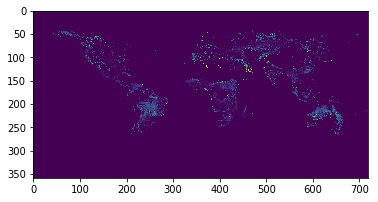

In [53]:
with rio.open(out_fn) as src:
    arr = src.read(1)
    
plt.imshow(arr)

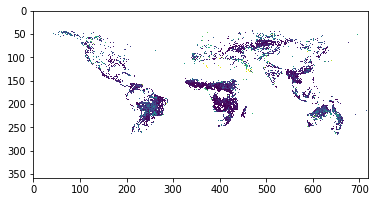

In [54]:
plt.imshow(np.ma.masked_equal(arr,0))

In [57]:
meta_new

{'driver': 'GRIB',
 'dtype': 'float32',
 'nodata': 0,
 'width': 719,
 'height': 359,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]'),
 'transform': Affine(0.5, 0.0, -179.75,
        0.0, -0.5, 89.75)}

In [15]:
import rasterio as rio

test_nc_from_john = '../fromJohn_Idaho/test1.nc'
ds = 'NETCDF:{}:tx'.format(test_nc_from_john)
with rio.open(ds) as src:
    meta = src.meta
    prof = src.profile
    arr = src.read(1)
    
meta

{'driver': 'netCDF',
 'dtype': 'float32',
 'nodata': -32768.0,
 'width': 1440,
 'height': 721,
 'count': 1,
 'crs': None,
 'transform': Affine(0.25, 0.0, -0.125,
        0.0, -0.25, 90.125)}

In [21]:
import pickle

grid_pickle = 'climate_grid_meta_0_25_wgs84.pickle'
with open(grid_pickle, 'wb') as f:
    pickle.dump(meta, f)

In [22]:
with open(grid_pickle, 'rb') as f:
    meta2 = pickle.load(f)
    
meta2

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -32768.0,
 'width': 1440,
 'height': 721,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.25, 0.0, -0.125,
        0.0, -0.25, 90.125)}

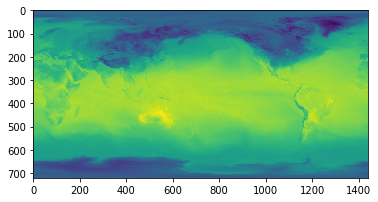

In [9]:
plt.imshow(arr)

In [27]:
with rio.open('../fromJohn_Idaho/tx_arc.tif') as src:
    meta = src.meta

In [28]:
meta, prof, (-180 + .25/2, 90 - .25/2)


({'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': -32768.0,
  'width': 1440,
  'height': 721,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.25, 0.0, -0.125,
         0.0, -0.25, 90.125)},
 {'driver': 'netCDF', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': None, 'transform': Affine(0.25, 0.0, -0.125,
        0.0, -0.25, 90.125), 'tiled': False},
 (-179.875, 89.875))

In [29]:
new_aff = rio.Affine(0.25, 0.0, -179.875, 0.0, -0.25, 89.875)
meta.update(transform=new_aff)
meta.update(dtype='float32')
meta.update(driver='GTiff')

grid_pickle = 'climate_grid_meta_0_25_wgs84.pickle'
with open(grid_pickle, 'wb') as f:
    pickle.dump(meta, f)